### Athens University of Economics and Business
### Department of Management Science & Technology
### Msc in Business Analytics

### Course : Machine Learning & Content Analytics
* Instructors : H.Papageorgiou, G.Perakis
* Students : Xheni Cobanaj (f2822117), Nikolaos Matzakos (f2822107), Dimitris Papageorgiou (f2822109)

* Import of necessary libraries :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline

import re
import itertools
import string
import collections
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Embedding,Flatten,Dropout,Activation
from tensorflow.python.keras import metrics,regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Model
from tensorflow.keras.layers import LSTM, Input, Concatenate, Bidirectional, concatenate
from tqdm import tqdm
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D , MaxPooling1D
from keras.layers.core import Reshape, Flatten
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

In [2]:
#!pip install tensorflow==2.8
#!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [3]:
# df = pd.read_csv("mbti_1.csv",header=0)
# df.head()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/MyDrive/mbti_1.csv"

/bin/bash: ls /content/drive/MyDrive/mbti_1.csv: No such file or directory


In [7]:
df=pd.read_csv("/content/drive/MyDrive/mbti_1.zip",header=0)
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


# **Data Cleaning & Preparation**

In [8]:
def text_cleaning(text):
  
  # make all characters lowercase
  text = text.lower()

  # removing the posts delimiter  
  text = text.replace("|"," ") 

  # removing the urls
  text = re.sub(r'https?:\/\/.*?[\s+]', '',text)

  # removing Punctation
  text = re.sub('[%s]*' % string.punctuation, '',text)

  # removing numbers
  text = re.sub('[0-9]+','', text)
   
  # removing non-words 
  text = re.sub(r'[^a-zA-Z\s]','',text)

  # removing the personallity type codes 
  pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
  pers_types = [p.lower() for p in pers_types]
  
  for t in pers_types:
      text = text.replace(t,"")


  # removing big spaces
  text = re.sub(' +', ' ', text) 

  

  return(text)  

In [9]:
# function for producing the four binary target variables
def categories(df):
  df['Extraversion'] = ''
  df['Sensing'] = ''
  df['Thinking'] = ''
  df['Judging'] = ''

  for i in df.index:    
    if "E" in df['type'][i]:
      df['Extraversion'][i] = 1
    else:
      df['Extraversion'][i] = 0

    if "S" in df['type'][i]:
      df['Sensing'][i] = 1
    else:
      df['Sensing'][i] = 0
    
    if "T" in df['type'][i]:
      df['Thinking'][i] = 1
    else:
      df['Thinking'][i] = 0
    
    if "J" in df['type'][i]:
      df['Judging'][i] = 1
    else:
      df['Judging'][i] = 0
  return(df)

In [10]:
data = df.copy()

In [11]:
data['tokens'] = data['posts'].apply(lambda s : s.split('|||'))
data = data.explode('tokens').reset_index()
data.head()

,index,type,posts,tokens
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp and intj moments https://www.youtube.com...
3,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,What has been the most life-changing experienc...
4,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


In [12]:
data['tokens'] = data.tokens.str.split()

In [13]:
data['selected_tokens'] = data.tokens.apply(lambda arr : ' '.join(arr[:6]))

In [14]:
data_tr= data.groupby('index').agg({'selected_tokens': lambda arr : ' '.join(arr)})
data_tr = pd.concat([data_tr,df['type']], axis=1)
data_tr

,selected_tokens,type
0,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,INFJ
1,'I'm finding the lack of me Sex can be boring ...,ENTP
2,'Good one _____ https://www.youtube.com/watch?...,INTP
3,"'Dear INTP, I enjoyed our conversation Dear EN...",INTJ
4,'You're fired. That's another silly misconcept...,ENTJ
...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908 I...,ISFP
8671,'So...if this thread already exists someplace ...,ENFP
8672,'So many questions when i do I worked in a bre...,INTP
8673,'I am very conflicted right now If I had to gu...,INFP


In [15]:
categories(data_tr)

,selected_tokens,type,Extraversion,Sensing,Thinking,Judging
0,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,INFJ,0,0,0,1
1,'I'm finding the lack of me Sex can be boring ...,ENTP,1,0,1,0
2,'Good one _____ https://www.youtube.com/watch?...,INTP,0,0,1,0
3,"'Dear INTP, I enjoyed our conversation Dear EN...",INTJ,0,0,1,1
4,'You're fired. That's another silly misconcept...,ENTJ,1,0,1,1
...,...,...,...,...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908 I...,ISFP,0,1,0,0
8671,'So...if this thread already exists someplace ...,ENFP,1,0,0,0
8672,'So many questions when i do I worked in a bre...,INTP,0,0,1,0
8673,'I am very conflicted right now If I had to gu...,INFP,0,0,0,0


In [16]:
data_tr['selected_tokens'] = data_tr.selected_tokens.apply(text_cleaning)

In [17]:
data_tr.head()

,selected_tokens,type,Extraversion,Sensing,Thinking,Judging
0,and moments sportscenter what has been the mo...,INFJ,0,0,0,1
1,im finding the lack of me sex can be boring if...,ENTP,1,0,1,0
2,good one of course to which i say does being a...,INTP,0,0,1,0
3,dear i enjoyed our conversation dear sub long ...,INTJ,0,0,1,1
4,youre fired thats another silly misconception ...,ENTJ,1,0,1,1


In [18]:
data_tr['posts_length'] = data_tr['selected_tokens'].apply(lambda x : len(x.split(' ')))

<Figure size 1152x576 with 0 Axes>

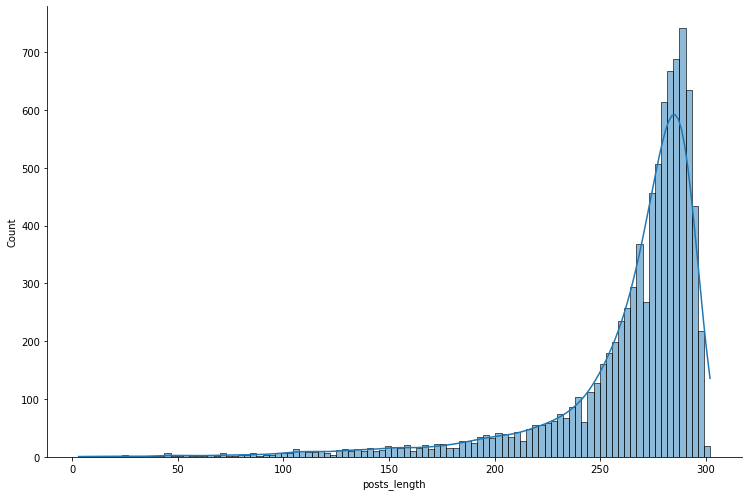

In [19]:
plt.figure(figsize=(16,8))
sns.displot(data_tr.posts_length,kde=True,height=7,aspect=1.5)
plt.show()

In [20]:
print("Max :",data_tr.posts_length.max())
print("Mean :",data_tr.posts_length.mean())
print("Median :",data_tr.posts_length.median())
print("Mode :",data_tr.posts_length.mode())

Max : 302
Mean : 263.41821325648414
Median : 277.0
Mode : 0    289
dtype: int64


# **Data Split**

In [21]:
X = data_tr['selected_tokens']
y = data_tr[['Extraversion','Sensing','Thinking','Judging']]
X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.1,
                                                            random_state=20,
                                                            stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10, 
                                                  random_state=20,
                                                  stratify=y_train_val)

# Encoding Target

In [22]:
y_train_enc = np.array(y_train).astype('float32')
y_val_enc = np.array(y_val).astype('float32')
y_test_enc = np.array(y_test).astype('float32')

In [23]:
# vocabulary_size=min(len(word_index)+1,(NUM_WORDS))


# Tokenization and Padding Process

In [24]:
max_words = 35000

tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
tokenizer

In [25]:
tokenizer.fit_on_texts(X_train)

In [26]:
X_train_enc  = tokenizer.texts_to_sequences(X_train)
X_val_enc  = tokenizer.texts_to_sequences(X_val)
X_test_enc  = tokenizer.texts_to_sequences(X_test)

In [27]:
word_index = tokenizer.word_index

for w in ['ten', 'love', 'top']:
     print(f'Token for the word "{w}": {word_index[w]}')

Token for the word "ten": 1818
Token for the word "love": 54
Token for the word "top": 723


In [28]:
maxlen = 280

X_train_enc = pad_sequences(X_train_enc,padding='pre',maxlen=maxlen)
X_val_enc = pad_sequences(X_val_enc,padding='pre', maxlen=maxlen)
X_test_enc = pad_sequences(X_test_enc, padding='pre', maxlen=maxlen)

print('New data shape: {}'.format(X_train_enc.shape))
print('New data shape: {}'.format(X_val_enc.shape))
print('New data shape: {}'.format(X_test_enc.shape))

New data shape: (7026, 280)
New data shape: (781, 280)
New data shape: (868, 280)


# Glove pretrained embeddings

In [29]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-08-26 13:42:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-26 13:42:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-26 13:42:09--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [30]:
def load_glove_embeddings(dim: int = 100) -> dict:
    """
    Function that loads glove embeddings. 

    :param dim: The embeddings size (dimensions)
    :return:
    """
    print('Loading word vectors')

    embed_index = dict()  # We create a dictionary of word -> embedding

    fname = 'glove.6B.{}d.txt'.format(dim)

    f = open(fname, encoding="utf8")  # Open file

    # In the dataset, each line represents a new word embedding
    # The line starts with the word and the embedding values follow
    for line in tqdm(f, desc='Loading Embeddings', unit='word'):
        values = line.split()
        # The first value is the word, the rest are the values of the embedding
        word = values[0]
        # Load embedding
        embedding = np.asarray(values[1:], dtype='float32')

        # Add embedding to our embedding dictionary
        embed_index[word] = embedding
    f.close()

    print('Found %s word vectors.' % len(embed_index))

    return embed_index

In [31]:
embedding_dim = 300

embeddings_index = load_glove_embeddings(dim=embedding_dim)

Loading word vectors


Loading Embeddings: 400000word [00:24, 16564.61word/s]

Found 400000 word vectors.


In [32]:
def create_embeddings_matrix(emb_index: dict,
                             tokenizer: Tokenizer,
                             emb_dim: int = 100) -> np.ndarray:
    """

    :param emb_index: Embeddings Index
    :param tokenizer: Keras fitted tokenizer.
    :param emb_dim: Embeddings dimension.
    :return: A matrix of shape (nb_words, emb_dim) containing the glove embeddings.
    """
    assert emb_dim in [50, 100, 200, 300]

    # Create a matrix of all embeddings
    # (stacking=concatenating all the vectors)
    all_embs = np.stack(emb_index.values())  # .values() gets the all the arrays from the keys

    # Calculate mean
    emb_mean = all_embs.mean()
    # Calculate standard deviation
    emb_std = all_embs.std()

    print("Embeddings AVG: {} | STD: {}".format(emb_mean, emb_std))

    # We can now create an embedding matrix holding all word vectors.

    word_index = tokenizer.word_index

    # How many words are there actually. Because we may have requested X most common tokens
    # and the total tokens are X/2
    nb_words = min(max_words, len(word_index))

    # Create a random matrix with the same mean and std as the embeddings

    embedding_matrix = np.random.normal(emb_mean,  # mean
                                        emb_std,  # std
                                        (nb_words, emb_dim)) # shape of the matrix

    # The vectors need to be in the same position as their index.
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
    
    counter = 0
    
    # Loop over all words in the word index
    for word, i in word_index.items():  # .items() return a tuple with (word, word_index)

        # If we are above the amount of words we want to use we do nothing
        if i >= max_words:
            continue

        # Get the embedding vector for the word
        embedding_vector = emb_index.get(word)

        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            counter += 1
    
    print(f'Found {counter} pre-trained embeddings out of {nb_words}')
    
    return embedding_matrix

In [33]:
embedding_matrix = create_embeddings_matrix(emb_index=embeddings_index,
                                            tokenizer=tokenizer,
                                            emb_dim=embedding_dim)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Embeddings AVG: -0.003905011573806405 | STD: 0.3817702829837799
Found 25173 pre-trained embeddings out of 35000


# CNN Model

## Model Callbacks

In [34]:
monitor = 'val_loss'

model_cnn_fname = 'model_cnn.h5'

callbacks_cnn = [
    
    # Stop training when a monitored quantity has stopped improving.
    EarlyStopping(monitor=monitor,
                  min_delta = 0, 
                  patience=5,
                  verbose=1,
                  restore_best_weights=True),
    
    # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath=model_cnn_fname,
                    monitor=monitor,
                    save_best_only=True,
                    save_weights_only=False,
                    verbose=1),
    
    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor=monitor,
                      factor=0.1,
                      patience=3,
                      verbose=1,
                      restore_best_weights=True)

]


## Model Architecture

In [66]:
# cnn network hyperparameters

nb_classes = len(y_train_enc[0])
embedding_dim = 300
maxlen=280
max_words=35000
nof_filters = 32
kernel_size = 5 
hidden_dims = 300  
print('Number of Classes (Personality Components): {}'.format(nb_classes))
print('Number of filters: {}'.format(nof_filters))
print('Kernel size: {}'.format(kernel_size))
print('Number of hidden layers: {}'.format(hidden_dims))



#Setting model hyperparameters
batch_size=128 #  =>  in each iteration, we consider 100 training examples at once
num_epochs=50

Number of Classes (Personality Components): 4
Number of filters: 32
Kernel size: 5
Number of hidden layers: 300


In [69]:
# Convolutional layer 
# since we have a multiclass classification scheme with 4 classes, we selece FOUR neurons with SIGMOID activation.
print('Building model...')

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False),
    tf.keras.layers.Conv1D(nof_filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(hidden_dims, activation= 'relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(nb_classes, activation='sigmoid')
])


# Compile model
# We have a multi-label problem to solve with 4 classes
# that's why we will compile the model using binary_crossentropy as a loss function. 
# We will also use adam as an optimizer and Accuracy and Binary Accuracy as metrics

model_cnn.compile(loss='binary_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['binary_accuracy','accuracy'])
model_cnn.summary()

Building model...
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 280, 300)          10500000  
                                                                 
 conv1d_13 (Conv1D)          (None, 276, 32)           48032     
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_26 (Dense)            (None, 300)               9900      
                                                                 
 dropout_15 (Dropout)        (None, 300)               0         
                                                                 
 dense_27 (Dense)            (None, 4)                 1204      
                                   

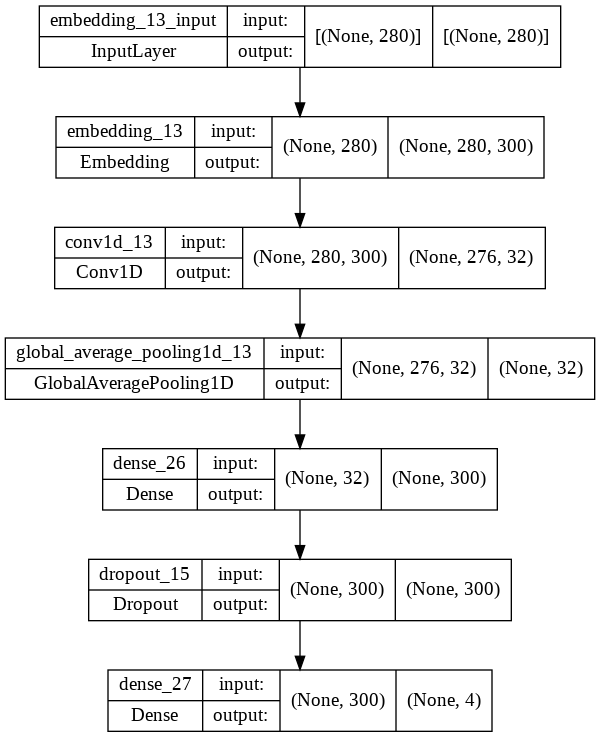

In [70]:
plot_model(model_cnn,show_shapes=True)

In [71]:
#We train (fit our data to) our model
history_cnn = model_cnn.fit(X_train_enc,                               # features
    y_train_enc,                               # labels
    epochs=num_epochs,                          # numbers of epoch
    batch_size=batch_size,                  # define batch size
    verbose=1,                              # the most extended verbose
    validation_data=(X_val_enc, y_val_enc),   
    callbacks=callbacks_cnn
)

Epoch 1/50
52/55 [===========================>..] - ETA: 0s - loss: 0.5910 - binary_accuracy: 0.6854 - accuracy: 0.2500
Epoch 00001: val_loss did not improve from 0.50982
55/55 [==============================] - 1s 13ms/step - loss: 0.5891 - binary_accuracy: 0.6872 - accuracy: 0.2502 - val_loss: 0.5708 - val_binary_accuracy: 0.6933 - val_accuracy: 0.2753 - lr: 0.0010
Epoch 2/50
52/55 [===========================>..] - ETA: 0s - loss: 0.5697 - binary_accuracy: 0.7092 - accuracy: 0.2752
Epoch 00002: val_loss did not improve from 0.50982
55/55 [==============================] - 0s 8ms/step - loss: 0.5678 - binary_accuracy: 0.7110 - accuracy: 0.2771 - val_loss: 0.5581 - val_binary_accuracy: 0.7206 - val_accuracy: 0.3035 - lr: 0.0010
Epoch 3/50
52/55 [===========================>..] - ETA: 0s - loss: 0.5600 - binary_accuracy: 0.7181 - accuracy: 0.2940
Epoch 00003: val_loss did not improve from 0.50982
55/55 [==============================] - 0s 8ms/step - loss: 0.5600 - binary_accuracy: 0.7

## Model Evaluation


In [48]:
score_cnn = model_cnn.evaluate(
    X_val_enc,                 
    y_val_enc,                 
    batch_size=batch_size,   
    verbose=1                
)


7/7 [==============================] - 0s 6ms/step - loss: 0.5098 - binary_accuracy: 0.7519 - accuracy: 0.3675


In [72]:
print('\nValidation binary_crossentropy: {}'.format(score_cnn[0]))
print('\nValidation binary accuracy: {:.3f} %'.format(score_cnn[1]*100))
print('\nValidation accuracy: {:.3f} %'.format(score_cnn[2]*100))


Validation binary_crossentropy: 0.5098198652267456

Validation binary accuracy: 75.192 %

Validation accuracy: 36.748 %


In [73]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

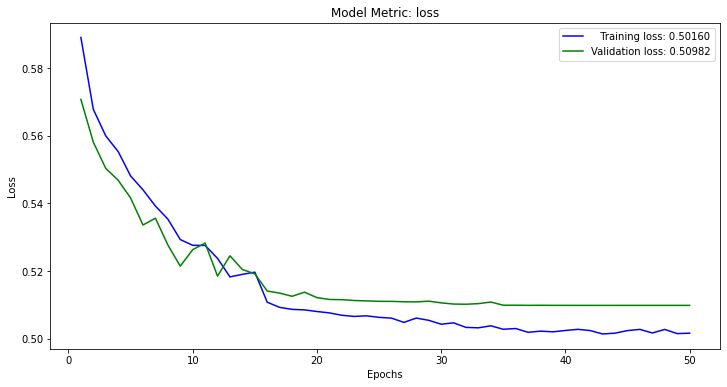

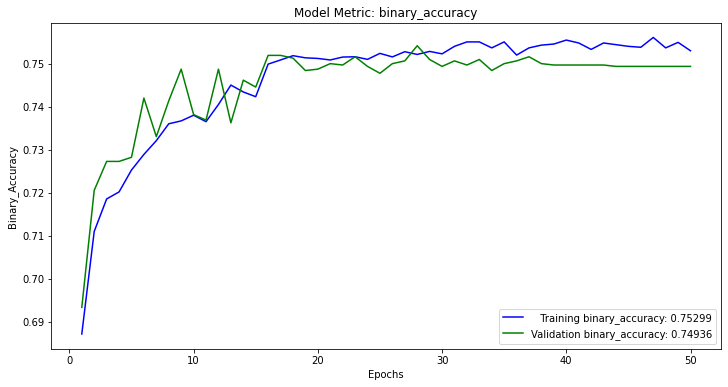

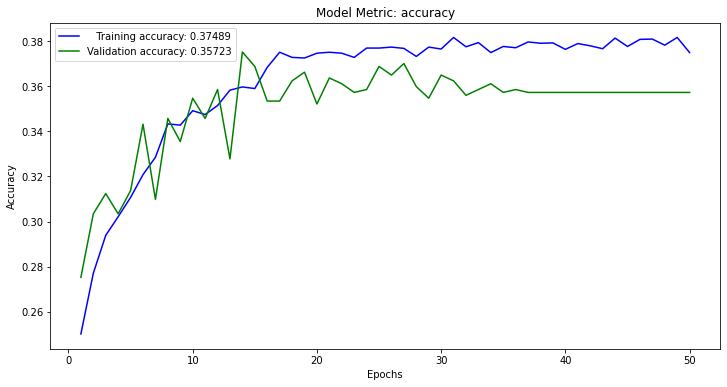

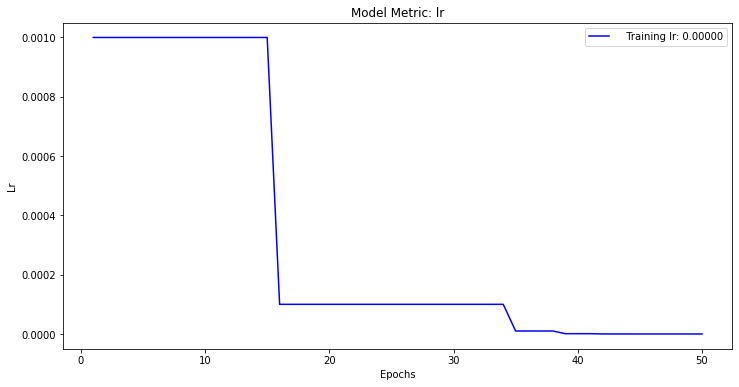

In [74]:
plot_keras_history(history_cnn)

In [ ]:
# from tensorflow.python.keras.models import load_model

# model_cnn.save('model_cnn.h5')  # creates a HDF5 file 'my_model.h5'

# # returns a compiled model
# # identical to the previous one
# model = load_model('my_model.h5')

In [93]:
model_cnn.save_weights('model_cnn_weights.h5')

# CRNN Model

In [75]:
# cnn-lstm network hyperparameters

nb_classes = len(y_train_enc[0])

dropout_rate = 0.4

nof_filters = 128

kernel_size = 3

print('Number of Classes (Personality Components): {}'.format(nb_classes))
print('Kernel size: {}'.format(kernel_size))
print('Number of filters: {}'.format(nof_filters))
print('Dropout rate: {}'.format(dropout_rate))

#model hyperparameters
num_epochs = 50
batch_size = 256

Number of Classes (Personality Components): 4
Kernel size: 3
Number of filters: 128
Dropout rate: 0.4


## Model Callbacks

In [78]:
monitor = 'val_loss'

model_cnn_rnn_fname= 'model_cnn_rnn.h5'

callbacks_cnn_rnn = [
    # Stop training when a monitored quantity has stopped improving.
    EarlyStopping(monitor=monitor,
                  patience=5,
                  verbose=1,
                  restore_best_weights=True),
    
    # # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath=model_cnn_rnn_fname,
                    monitor=monitor,
                    save_best_only=True,
                    save_weights_only=False,
                    verbose=1),
    
    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor=monitor,
                      factor=0.1,
                      patience=3,
                      verbose=1,
                      restore_best_weights=True)

]

## Model Architecture

In [87]:
# instantiate model
# print ('Building model...')

# model_cnn_rnn = Sequential()
# model_cnn_rnn.add(Embedding(max_words, embedding_dim,input_length=maxlen, weights=[embedding_matrix], trainable=False))
# model_cnn_rnn.add(Conv1D(nof_filters,kernel_size=kernel_size,padding='same',activation='relu'))
# model_cnn_rnn.add(MaxPooling1D(pool_size=20))
# model_cnn_rnn.add(Dropout(dropout_rate))
# model_cnn_rnn.add(LSTM(64,return_sequences=True))
# model_cnn_rnn.add(Dropout(0.25))
# model_cnn_rnn.add(Flatten())
# model_cnn_rnn.add(Dense(32,activation='relu'))
# model_cnn_rnn.add(Dropout(0.45))
# model_cnn_rnn.add(Dense(nb_classes,activation='sigmoid'))


print('Building model...')

model_cnn_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False),
    tf.keras.layers.Conv1D(nof_filters,kernel_size=kernel_size,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=20),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(nb_classes, activation='sigmoid')
])
model_cnn_rnn.summary()

Building model...
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 280, 300)          10500000  
                                                                 
 conv1d_16 (Conv1D)          (None, 280, 128)          115328    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 14, 128)          0         
 1D)                                                             
                                                                 
 dropout_22 (Dropout)        (None, 14, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 14, 64)            49408     
                                                                 
 dropout_23 (Dropout)        (None, 14, 64)            0         
                                   

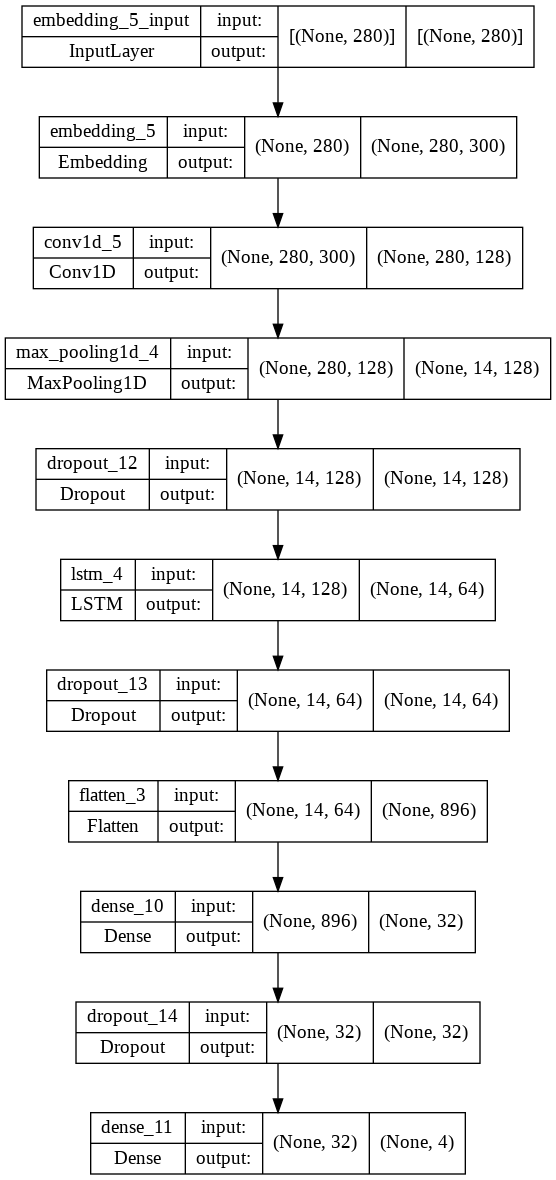

In [ ]:
plot_model(model_cnn_rnn,show_shapes=True)

In [88]:
#model compile
model_cnn_rnn.compile(optimizer= 'adam',loss ='binary_crossentropy', metrics=['binary_accuracy','accuracy'])

In [89]:
#fit train data to the model
hist_cnn_rnn = model_cnn_rnn.fit(
    x=X_train_enc,          
    y=y_train_enc,           
    batch_size=batch_size,   
    epochs=num_epochs,         
    verbose=1,               
    validation_data=(       
    X_val_enc,               
    y_val_enc),
    callbacks=callbacks_cnn_rnn
)

Epoch 1/50
27/28 [===========================>..] - ETA: 0s - loss: 0.6227 - binary_accuracy: 0.6613 - accuracy: 0.2442
Epoch 00001: val_loss did not improve from 0.53132
28/28 [==============================] - 3s 50ms/step - loss: 0.6226 - binary_accuracy: 0.6612 - accuracy: 0.2440 - val_loss: 0.5845 - val_binary_accuracy: 0.6911 - val_accuracy: 0.2753 - lr: 0.0010
Epoch 2/50
26/28 [==========================>...] - ETA: 0s - loss: 0.6024 - binary_accuracy: 0.6730 - accuracy: 0.2398
Epoch 00002: val_loss did not improve from 0.53132
28/28 [==============================] - 1s 27ms/step - loss: 0.6024 - binary_accuracy: 0.6730 - accuracy: 0.2384 - val_loss: 0.5820 - val_binary_accuracy: 0.6937 - val_accuracy: 0.2753 - lr: 0.0010
Epoch 3/50
27/28 [===========================>..] - ETA: 0s - loss: 0.5957 - binary_accuracy: 0.6777 - accuracy: 0.2383
Epoch 00003: val_loss did not improve from 0.53132
28/28 [==============================] - 1s 27ms/step - loss: 0.5952 - binary_accuracy: 0

## Model Evaluation

In [90]:
# evaluate and store on score variable on the TEST DATASET
score_cnn_rnn = model_cnn_rnn.evaluate(
    X_val_enc,    # features
    y_val_enc,              # labels
    batch_size=batch_size,   # batch size
    verbose=2                # the most extended verbose
)

4/4 - 0s - loss: 0.5246 - binary_accuracy: 0.7423 - accuracy: 0.3431 - 72ms/epoch - 18ms/step


In [91]:
print('\nValidation binary_crossentropy: {}'.format(score_cnn_rnn[0]))
print('\nValidation binary accuracy: {:.3f} %'.format(score_cnn_rnn[1]*100))
print('\nValidation accuracy: {:.3f} %'.format(score_cnn_rnn[2]*100))


Validation binary_crossentropy: 0.5245955586433411

Validation binary accuracy: 74.232 %

Validation accuracy: 34.315 %


In [ ]:
#save the weights of the model
model_cnn_rnn.save_weights('model_cnn_rnn_weights.h5')

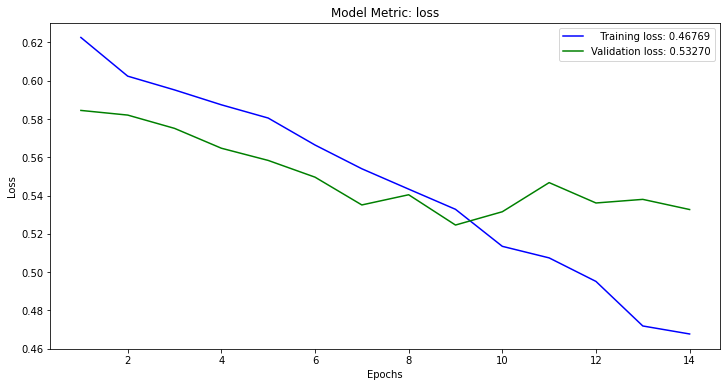

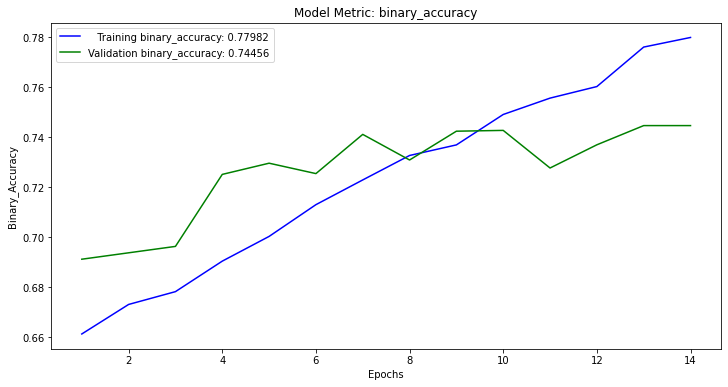

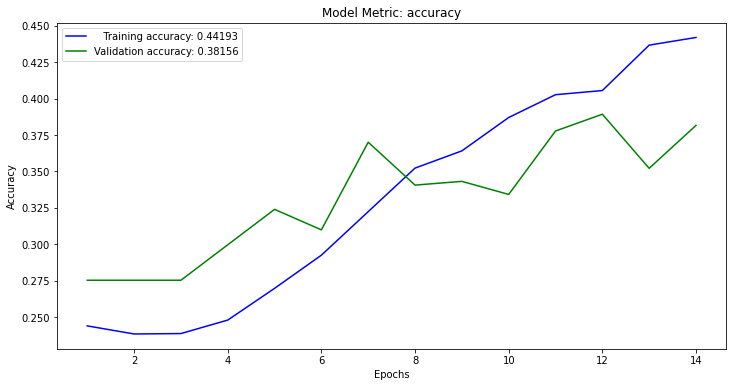

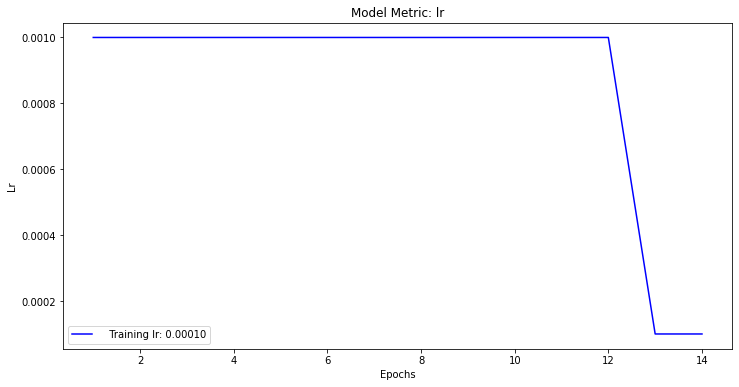

In [92]:
plot_keras_history(hist_cnn_rnn)

## Conclusion 

As we can observe, in this notebook we implemented one CNN model and one CRNN architecture. These two models performed quite well and have achieved high accuracy scores. Their evaluation summary can be found right below :

***CNN:***


Validation binary crossentropy: 0.509

Validation binary accuracy: 75.19 %

Validation accuracy: 36.74 %


***CRNN:***


Validation binary crossentropy: 0.524

Validation binary accuracy: 74.23 %

Validation accuracy: 34.31 %
